# Titanic Machine Learning - Exploratory Data Analysis (EDA)

This notebook explores the Titanic dataset to perform a preliminary analysis of the data. Our goal is to understand the distribution of features, relationships between variables, and identify potential issues such as missing data or outliers.


## 1. Importing Libraries and Loading Data

We will start by importing the necessary libraries and loading the Titanic dataset.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set styles for visualizations
plt.style.use("ggplot")
sns.set_theme(style="whitegrid")

# Load datasets
train = pd.read_csv("C:/Users/fouad/Documents/GitHub/Titanic_ML/data/train.csv")
test = pd.read_csv("C:/Users/fouad/Documents/GitHub/Titanic_ML/data/test.csv")

# Display the first few rows of the training data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Analysis of Missing Data


In [2]:
# Count missing values in training set
missing_values_train = train.isnull().sum().sort_values(ascending=False)
missing_values_train[missing_values_train > 0]

Cabin       687
Age         177
Embarked      2
dtype: int64

In [3]:
# Count missing values in test set
missing_values_test = test.isnull().sum().sort_values(ascending=False)
missing_values_test[missing_values_test > 0]

Cabin    327
Age       86
Fare       1
dtype: int64

In [4]:
# Count zero values in training set
missing_values_train_zero = (train == 0).sum().sort_values(ascending=False)
missing_values_train_zero[missing_values_train_zero > 0]

Parch       678
SibSp       608
Survived    549
Fare         15
dtype: int64

In [5]:
# Count zero values in test set
missing_values_test_zero = (test == 0).sum().sort_values(ascending=False)
missing_values_test_zero[missing_values_test_zero > 0]

Parch    324
SibSp    283
Fare       2
dtype: int64

### Visualizing Missing Values

The heatmap below illustrates the missing data in both the training and test datasets.


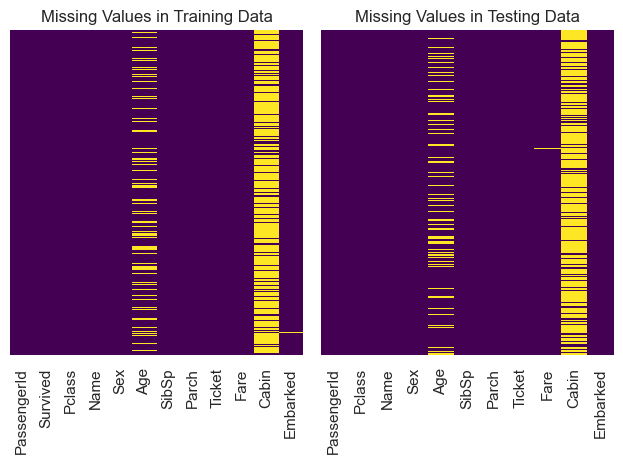

In [6]:
fig, axes = plt.subplots(1, 2)

sns.heatmap(train.isnull(), cmap="viridis", cbar=False, yticklabels=False, ax=axes[0])
axes[0].set_title("Missing Values in Training Data")

sns.heatmap(test.isnull(), cmap="viridis", cbar=False, yticklabels=False, ax=axes[1])
axes[1].set_title("Missing Values in Testing Data")

plt.tight_layout()
plt.show()

### Observations

The analysis reveals that several columns contain missing values, notably `Age`, `Cabin`, and `Embarked`. The `Cabin` column has more than 75% missing values, suggesting it may be either uninformative or difficult to impute reliably. To address this, I decided to extract only the first letter of the cabin number to indicate its location on the Titanic. If the cabin number is unknown, it will be labeled as "unknown.". The `Age` and `Fare` columns will be imputed by their median values, while `Embarked` will be filled with the mode.


## 3. Analysis of Survival Rate

We will examine the survival rates based on various features.


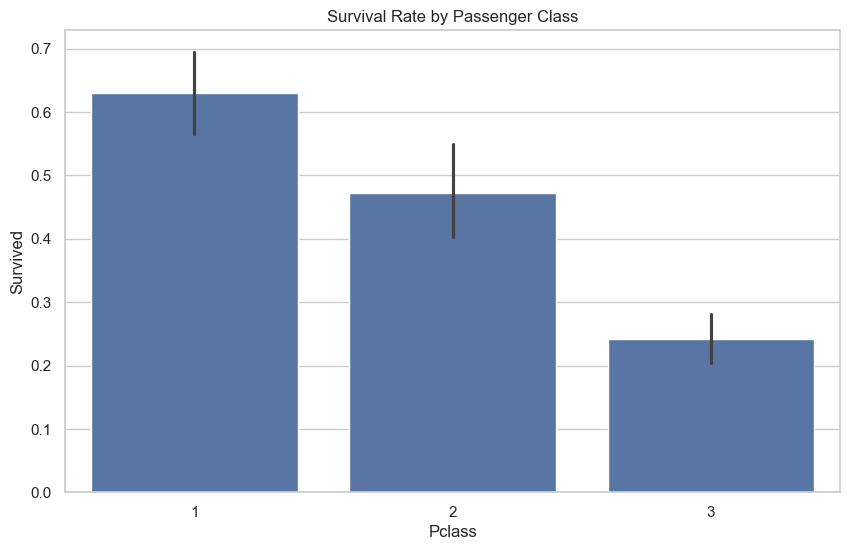

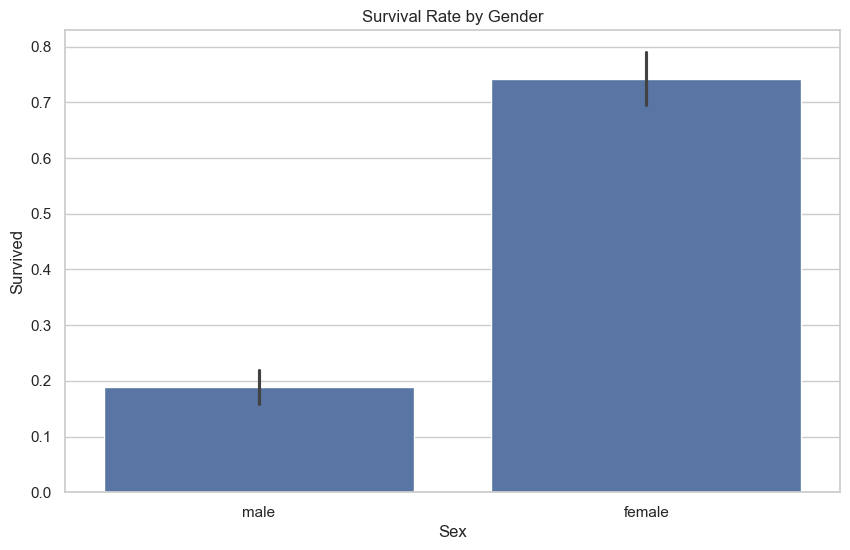

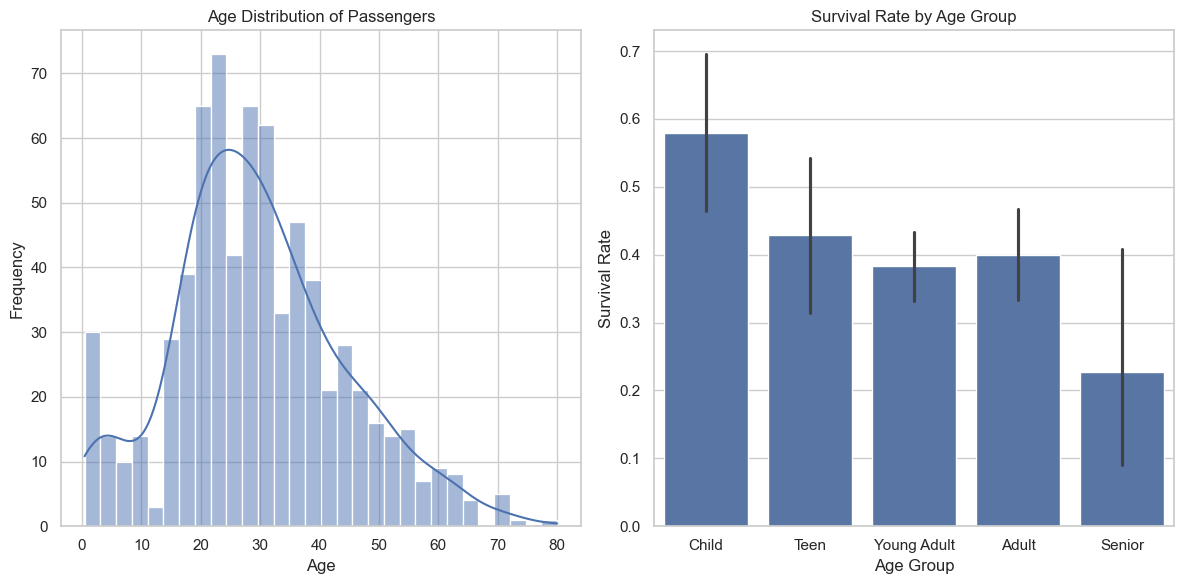

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Pclass", y="Survived", data=train)
plt.title("Survival Rate by Passenger Class")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Sex", y="Survived", data=train)
plt.title("Survival Rate by Gender")
plt.show()

train["AgeGroup"] = pd.cut(
    train["Age"],
    bins=[0, 12, 18, 35, 60, 100],
    labels=["Child", "Teen", "Young Adult", "Adult", "Senior"],
)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(train["Age"].dropna(), kde=True, bins=30, ax=axes[0])
axes[0].set_title("Age Distribution of Passengers")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Frequency")

sns.barplot(x="AgeGroup", y="Survived", data=train, ax=axes[1])
axes[1].set_title("Survival Rate by Age Group")
axes[1].set_xlabel("Age Group")
axes[1].set_ylabel("Survival Rate")

plt.tight_layout()
plt.show()

### Observations

The analysis shows that survival rates vary significantly based on factors like passenger class, gender, and age group. Women and children had higher survival rates, indicating possible prioritization during evacuation.


## 4. Correlation Analysis

Understanding the correlation between numerical features can help identify relationships in the dataset.


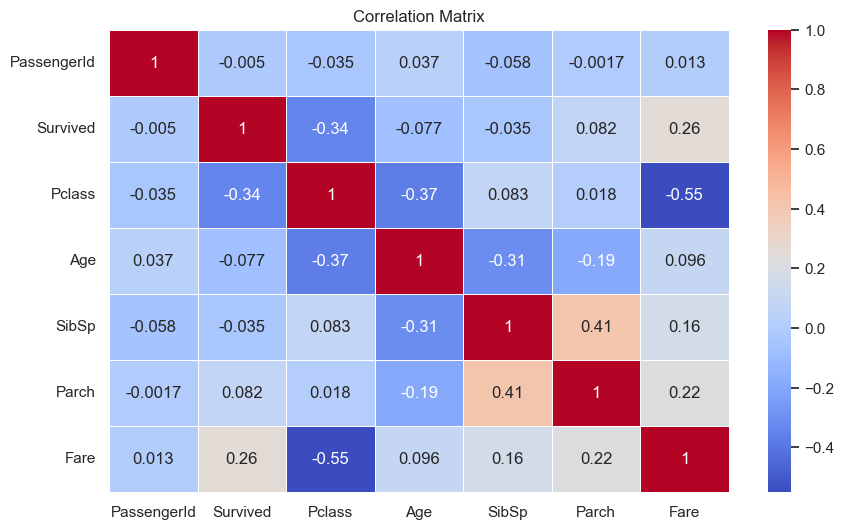

In [8]:
numeric_data = train.select_dtypes(include=[np.number])

plt.figure(figsize=(10, 6))
corr_matrix = numeric_data.corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

### Observations

Key relationships are observed, particularly between `Pclass`, `Sex`, and `Survived`. Further feature engineering will be essential for modeling.


## 5. Feature Engineering

### 5.1 Analysis of Cabin Information

Change `Cabin` to indicate his location.


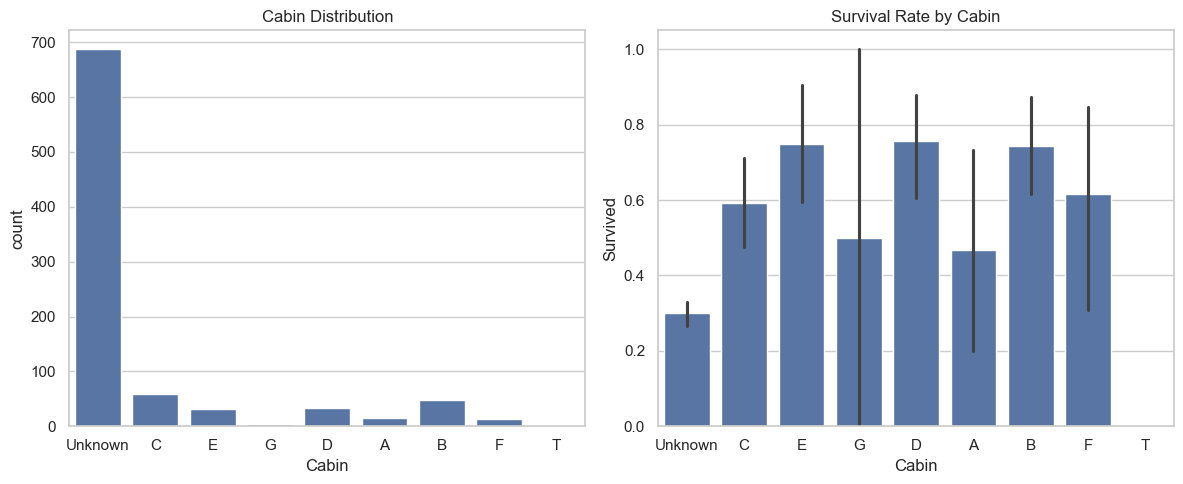

In [9]:
known_cabins = ["A", "B", "C", "D", "E", "F", "T", "G"]
train["Cabin"] = train["Cabin"].apply(
    lambda x: x[0] if pd.notnull(x) and x[0] in known_cabins else "Unknown"
)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x="Cabin", data=train, ax=axes[0])

axes[0].set_title("Cabin Distribution")

sns.barplot(x="Cabin", y="Survived", data=train, ax=axes[1])

axes[1].set_title("Survival Rate by Cabin")


plt.tight_layout()

plt.show()

### Observations

Passengers without cabin information had a lower survival rate. This suggests that missing cabin data might correlate with lower socioeconomic status or other survival-influencing factors.


### 5.2 Analysis of Passenger Titles

Extract passenger titles from the `Name` column and analyze their survival rates.


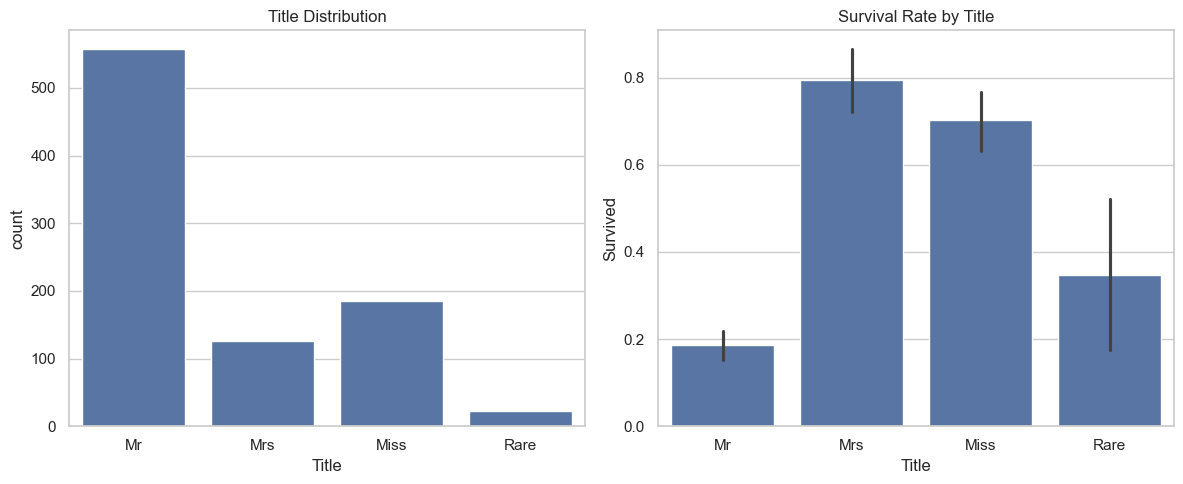

In [10]:
train["Title"] = train["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
title_replacements = {
    "Lady": "Rare",
    "Countess": "Rare",
    "Capt": "Rare",
    "Col": "Rare",
    "Don": "Rare",
    "Dr": "Rare",
    "Major": "Rare",
    "Rev": "Rare",
    "Sir": "Rare",
    "Jonkheer": "Rare",
    "Dona": "Rare",
    "Mlle": "Miss",
    "Ms": "Miss",
    "Mme": "Mrs",
    "Master": "Mr",
}
train["Title"] = train["Title"].replace(title_replacements)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x="Title", data=train, ax=axes[0])
axes[0].set_title("Title Distribution")

sns.barplot(x="Title", y="Survived", data=train, ax=axes[1])
axes[1].set_title("Survival Rate by Title")

plt.tight_layout()
plt.show()

### Observations

The survival rates vary by title, with titles like 'Miss' and 'Mrs' showing higher survival rates. This suggests that social status played a role in survival chances.


### 5.3 Analysis of Family Size

Create a new feature `FamilySize` based on siblings/spouses and parents/children.


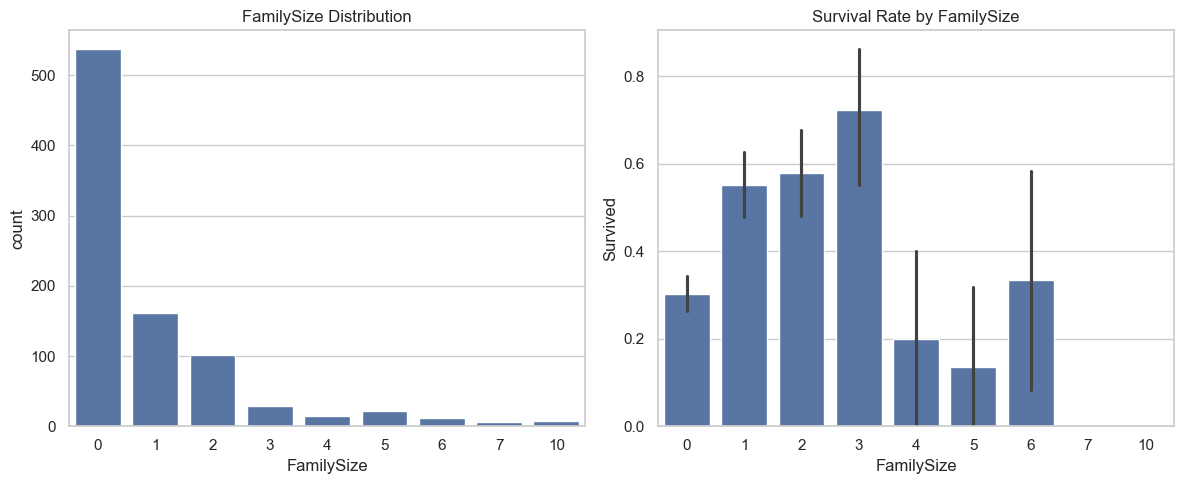

In [11]:
train["FamilySize"] = train["SibSp"] + train["Parch"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x="FamilySize", data=train, ax=axes[0])
axes[0].set_title("FamilySize Distribution")

sns.barplot(x="FamilySize", y="Survived", data=train, ax=axes[1])
axes[1].set_title("Survival Rate by FamilySize")

plt.tight_layout()
plt.show()

### Observations

Passengers traveling alone or in smaller families had a higher survival rate compared to larger families, which could indicate challenges in evacuation.


### 5.4 Analysis of Passengers Traveling Alone

Create a column `IsAlone` to indicate whether a passenger is traveling alone.


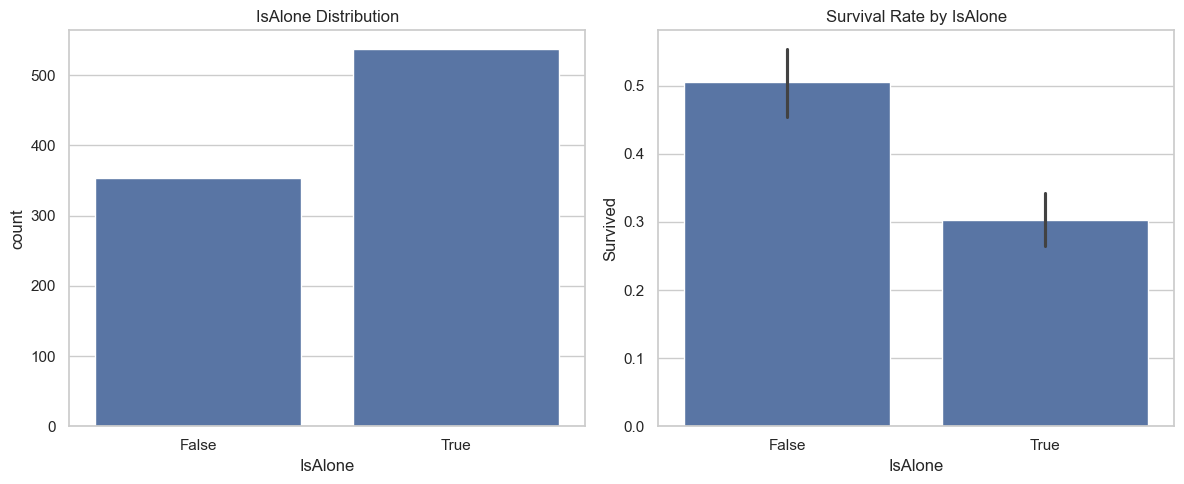

In [12]:
train["IsAlone"] = (train["FamilySize"] == 0).astype(bool)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x="IsAlone", data=train, ax=axes[0])
axes[0].set_title("IsAlone Distribution")

sns.barplot(x="IsAlone", y="Survived", data=train, ax=axes[1])
axes[1].set_title("Survival Rate by IsAlone")

plt.tight_layout()
plt.show()

### Observations

Those traveling alone had a lower survival rate compared to those traveling with others, suggesting that companionship may have facilitated survival during the crisis.


## 6. Conclusion

This exploratory data analysis (EDA) of the Titanic dataset has provided significant insights into the factors influencing passenger survival rates. We discovered important features, including `Age`, `Cabin`, and `Embarked`, which will be interesting in our modeling phase.